<a href="https://colab.research.google.com/github/guten-morgen3776/mnist-auto-encoder/blob/main/cnn_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(
    train=True,
    download=True,
    root="mnist",
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.64MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.85MB/s]


In [5]:
class ConvAutoencoder(nn.Module):
  def __init__(self):
    super(ConvAutoencoder, self).__init__() #nn.Moduleが持っている初期設定を自分のクラスで実行するコード

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=2, padding=1), #14*14へ
        #in_channels, out_channels, kernel_size
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1), #7*7
        nn.ReLU(),
        nn.Conv2d(32, 2, 7) #1*1
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(2, 32, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

model = ConvAutoencoder()
print(model)


ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 2, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(2, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


In [6]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

num_epochs = 4
for epoch in range(num_epochs):
  for data, _ in train_loader:
    img = data
    optimizer.zero_grad()
    recon = model(img)
    loss = loss_func(recon, img)
    loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

Epoch: 1, Loss: 0.056740839034318924
Epoch: 2, Loss: 0.05061190575361252
Epoch: 3, Loss: 0.05006163567304611
Epoch: 4, Loss: 0.04947366192936897


In [7]:
import matplotlib.pyplot as plt
model.eval() #学習ストップ
encoded_data = []
labels_list = []

with torch.no_grad():
  for data, label in train_loader:
    img = data
    z = model.encoder(img)
    encoded_data.append(z)
    labels_list.append(label)

encoded_prints = torch.cat(encoded_data)
all_labels = torch.cat(labels_list)

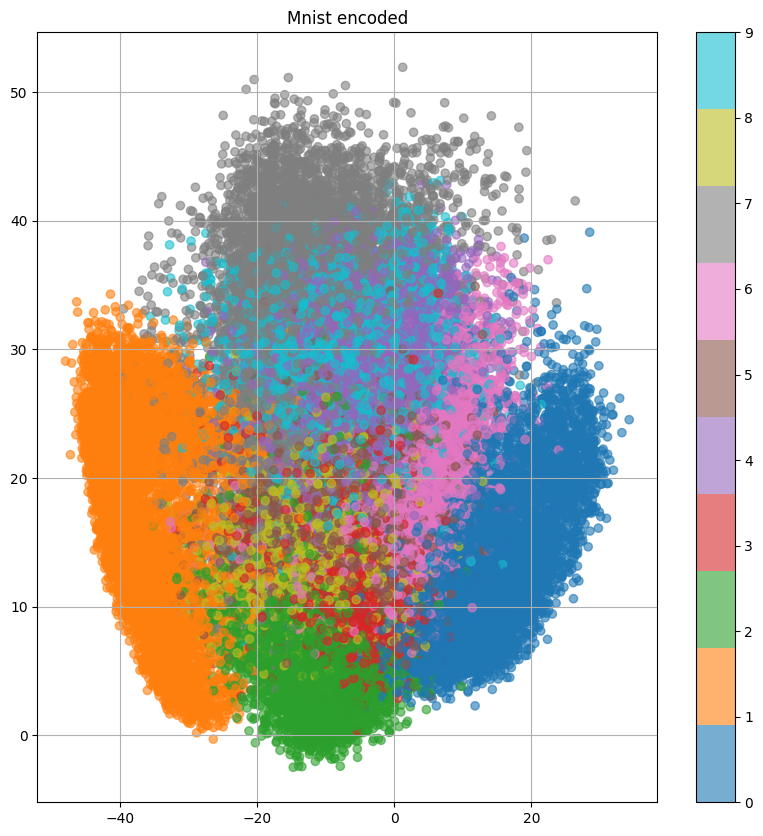

In [8]:
plt.figure(figsize=(10, 10))
plt.scatter(encoded_prints[:, 0], encoded_prints[:, 1], c=all_labels, cmap='tab10', alpha=0.6)
plt.colorbar()
plt.title('Mnist encoded')
plt.grid()
plt.show()

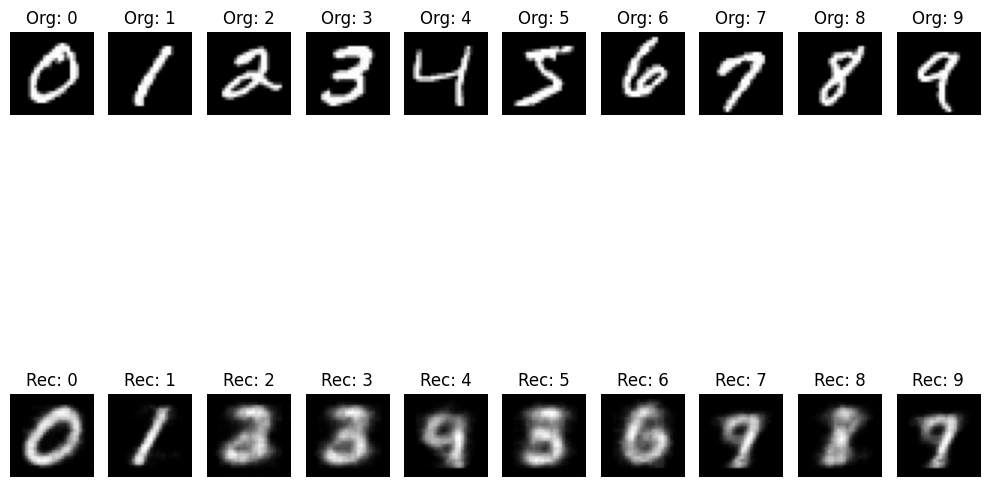

In [9]:
sample_images = {}
for data, label in train_dataset:
  if label not in sample_images:
    sample_images[label] = data
  if len(sample_images) == 10:
    break

plt.figure(figsize=(10, 10))
model.eval()

with torch.no_grad():
  for i in range(10):
    img = sample_images[i]
    recon = model(img)
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Org: {i}")
    plt.axis('off')

    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(recon.view(28, 28), cmap='gray')
    plt.title(f"Rec: {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()